# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse, io
import scanpy.api as sc
import json
from collections import Counter
import pickle

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.3.3 anndata==0.6.18 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 


## Create input adata

In [ ]:
df = pd.read_csv("data/NeuronalGeneCount.csv", index_col=0)
/print df.shape

df = df.drop_duplicates(keep='first').T
/print df.shape
df.to_pickle('data/df.pkl')
df.head()

In [ ]:
df = pd.read_pickle('data/df.pkl')

In [ ]:
np.save('data/cells.npy', df.index.values)
np.save('data/genes.npy', df.columns)

In [ ]:
m = sparse.csr_matrix(df.as_matrix().T)

io.mmwrite("data/matrix.mtx", m)
del m, df

## Start from here if adata is available

In [27]:
%%time
path = './data/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = np.load('data/genes.npy')
adata.obs_names = np.load('data/cells.npy')

... writing an h5ad cache file to speedup reading next time
Wall time: 5.7 s


In [28]:
adata.var_names_make_unique()

In [29]:
adata.shape

(7603, 12355)

## Preprocessing

**Note:** In notebooks and jupyter lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [ ]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata.shape

Plot some information about mitochondrial genes, important for quality control. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):
> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [ ]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata.shape

Actually do the filtering.

In [ ]:
adata = adata[adata.obs['n_genes'] < 1250, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [ ]:
adata.raw = sc.pp.log1p(adata, copy=True)

Per-cell normalize the data matrix $\mathbf{X}$. Many people would consider the normalized data matrix as the "relevant data" for visualization and differential testing (assessing feature importance). Until a common viewpoint is reached on this, the decision of what to consider "raw", is up to the user. We tend to recommend to use the normalized data for visualization and differential testing even though here, we use the non-normalized data for the sake of consistency with the Seurat tutorial.

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly-variable genes.

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.005, max_mean=6, min_disp=0.1)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [ ]:
adata = adata[:, filter_result.gene_subset]
adata.shape

Logarithmize the data.

In [ ]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

Save the result.

## PCA

Compute PCA and make a scatter plot.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

We now advertise visualizing the data using UMAP, see below. In particular, if you have large data, this will give you a notable speedup. Also, it is potentially more faithful to global topology: trajectories are better preserved.

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata)

As we set the `.raw` attribute of AnnData (a "frozen" state of the object at a point in the pipeline where we deemed the data "raw"), the previous plots showed the raw gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

In [ ]:
sc.pl.umap(adata, use_raw=False)

## Clustering the graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.louvain(adata)

Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

In [ ]:
sc.pl.umap(adata, color=['louvain'], save='/bla.png')

In [ ]:
adata.obs['louvain'].value_counts()

In [ ]:
adata.obs['louvain'].to_csv("seurat.csv", header = False)

## Finding marker genes

In [ ]:
adata.obs['louvain'].shape

Let us compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save='/test.pdf')

# Group all calls into one function

In [23]:
def run(df, prefix = 'all_no_impute', 
        min_genes=10, min_cells=3, min_mean=0.005, max_mean=6, min_disp=0.1, n_neighbors=10, n_pcs=40, filterData=True):
    np.save(f'data/{prefix}_cells.npy', df.index.values)
    np.save(f'data/{prefix}_genes.npy', df.columns)
    m = sparse.csr_matrix(df.values.T)
    io.mmwrite(f"data/{prefix}_matrix.mtx", m)
    del m
    adata = sc.read(f"data/{prefix}_matrix.mtx", cache=True).T  # transpose the data
    adata.var_names = np.load(f'data/{prefix}_genes.npy')
    adata.obs_names = np.load(f'data/{prefix}_cells.npy')
    adata.var_names_make_unique()
    print('Original size',adata.shape)
    if filterData:
        sc.pp.filter_cells(adata, min_genes=min_genes)
        sc.pp.filter_genes(adata, min_cells=min_cells)
    adata.raw = sc.pp.log1p(adata, copy=True)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if True:
        filter_result = sc.pp.filter_genes_dispersion(
        adata.X, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)
        sc.pl.filter_genes_dispersion(filter_result)
        adata = adata[:, filter_result.gene_subset]
    print('After dispersion filter',adata.shape)
    sc.pp.log1p(adata) # log transform
    sc.pp.regress_out(adata, ['n_counts'])
    sc.pp.scale(adata, max_value=10) # clip values with std > max_value
    # PCA transform
    sc.tl.pca(adata, svd_solver='arpack')
    
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    
    sc.tl.louvain(adata)
    sc.pl.umap(adata, color=['louvain'], save=f'/{prefix}.png')
    print(adata.obs['louvain'].value_counts())

    sc.tl.rank_genes_groups(adata, 'louvain')
    sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save=f'/{prefix}.pdf')
    # Write marker genes to file
    markerGenes = {}
    group_names = adata.uns['rank_genes_groups']['names'].dtype.names
    for group_name in group_names:
        gene_names = adata.uns['rank_genes_groups']['names'][group_name]
        scores = adata.uns['rank_genes_groups']['scores'][group_name]
        markerGenes[f'{prefix}_{group_name}'] = list(gene_names)
        
    with open("cluster_sizes.txt", "a") as myfile:
        myfile.write(f"\n\n{prefix} cluster sizes: \n{adata.obs['louvain'].value_counts()}")
        myfile.write(f"Marker genes per cluster:\n")
        json.dump(markerGenes, myfile, indent=4, sort_keys=True)
    return adata, markerGenes

def getCellsFromCluster(adata, clusterId = '0'):
    v = adata.obs['louvain']
    index = np.where(v.values == clusterId)[0]
    return v.index[index]

In [10]:
df = pd.read_pickle('data/df.pkl')

... writing an h5ad cache file to speedup reading next time
Original size (7603, 844)
After dispersion filter (7603, 844)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10.39)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:06.82) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:27.77) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.92) --> found 33 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/all_no_impute.png


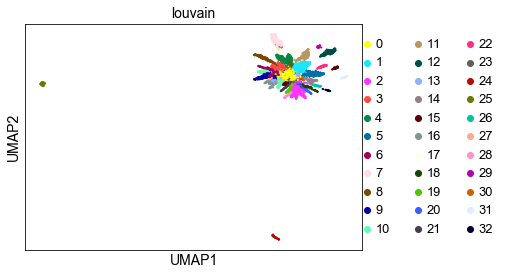

0     1119
1      825
2      473
3      464
4      453
5      396
6      360
7      360
8      310
9      287
10     280
11     260
12     249
13     177
14     144
15     136
16     128
17     128
18     117
19      93
20      91
21      90
22      87
23      86
24      73
25      73
26      70
27      64
28      57
29      41
30      41
31      36
32      35
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.47) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/all_no_impute.pdf


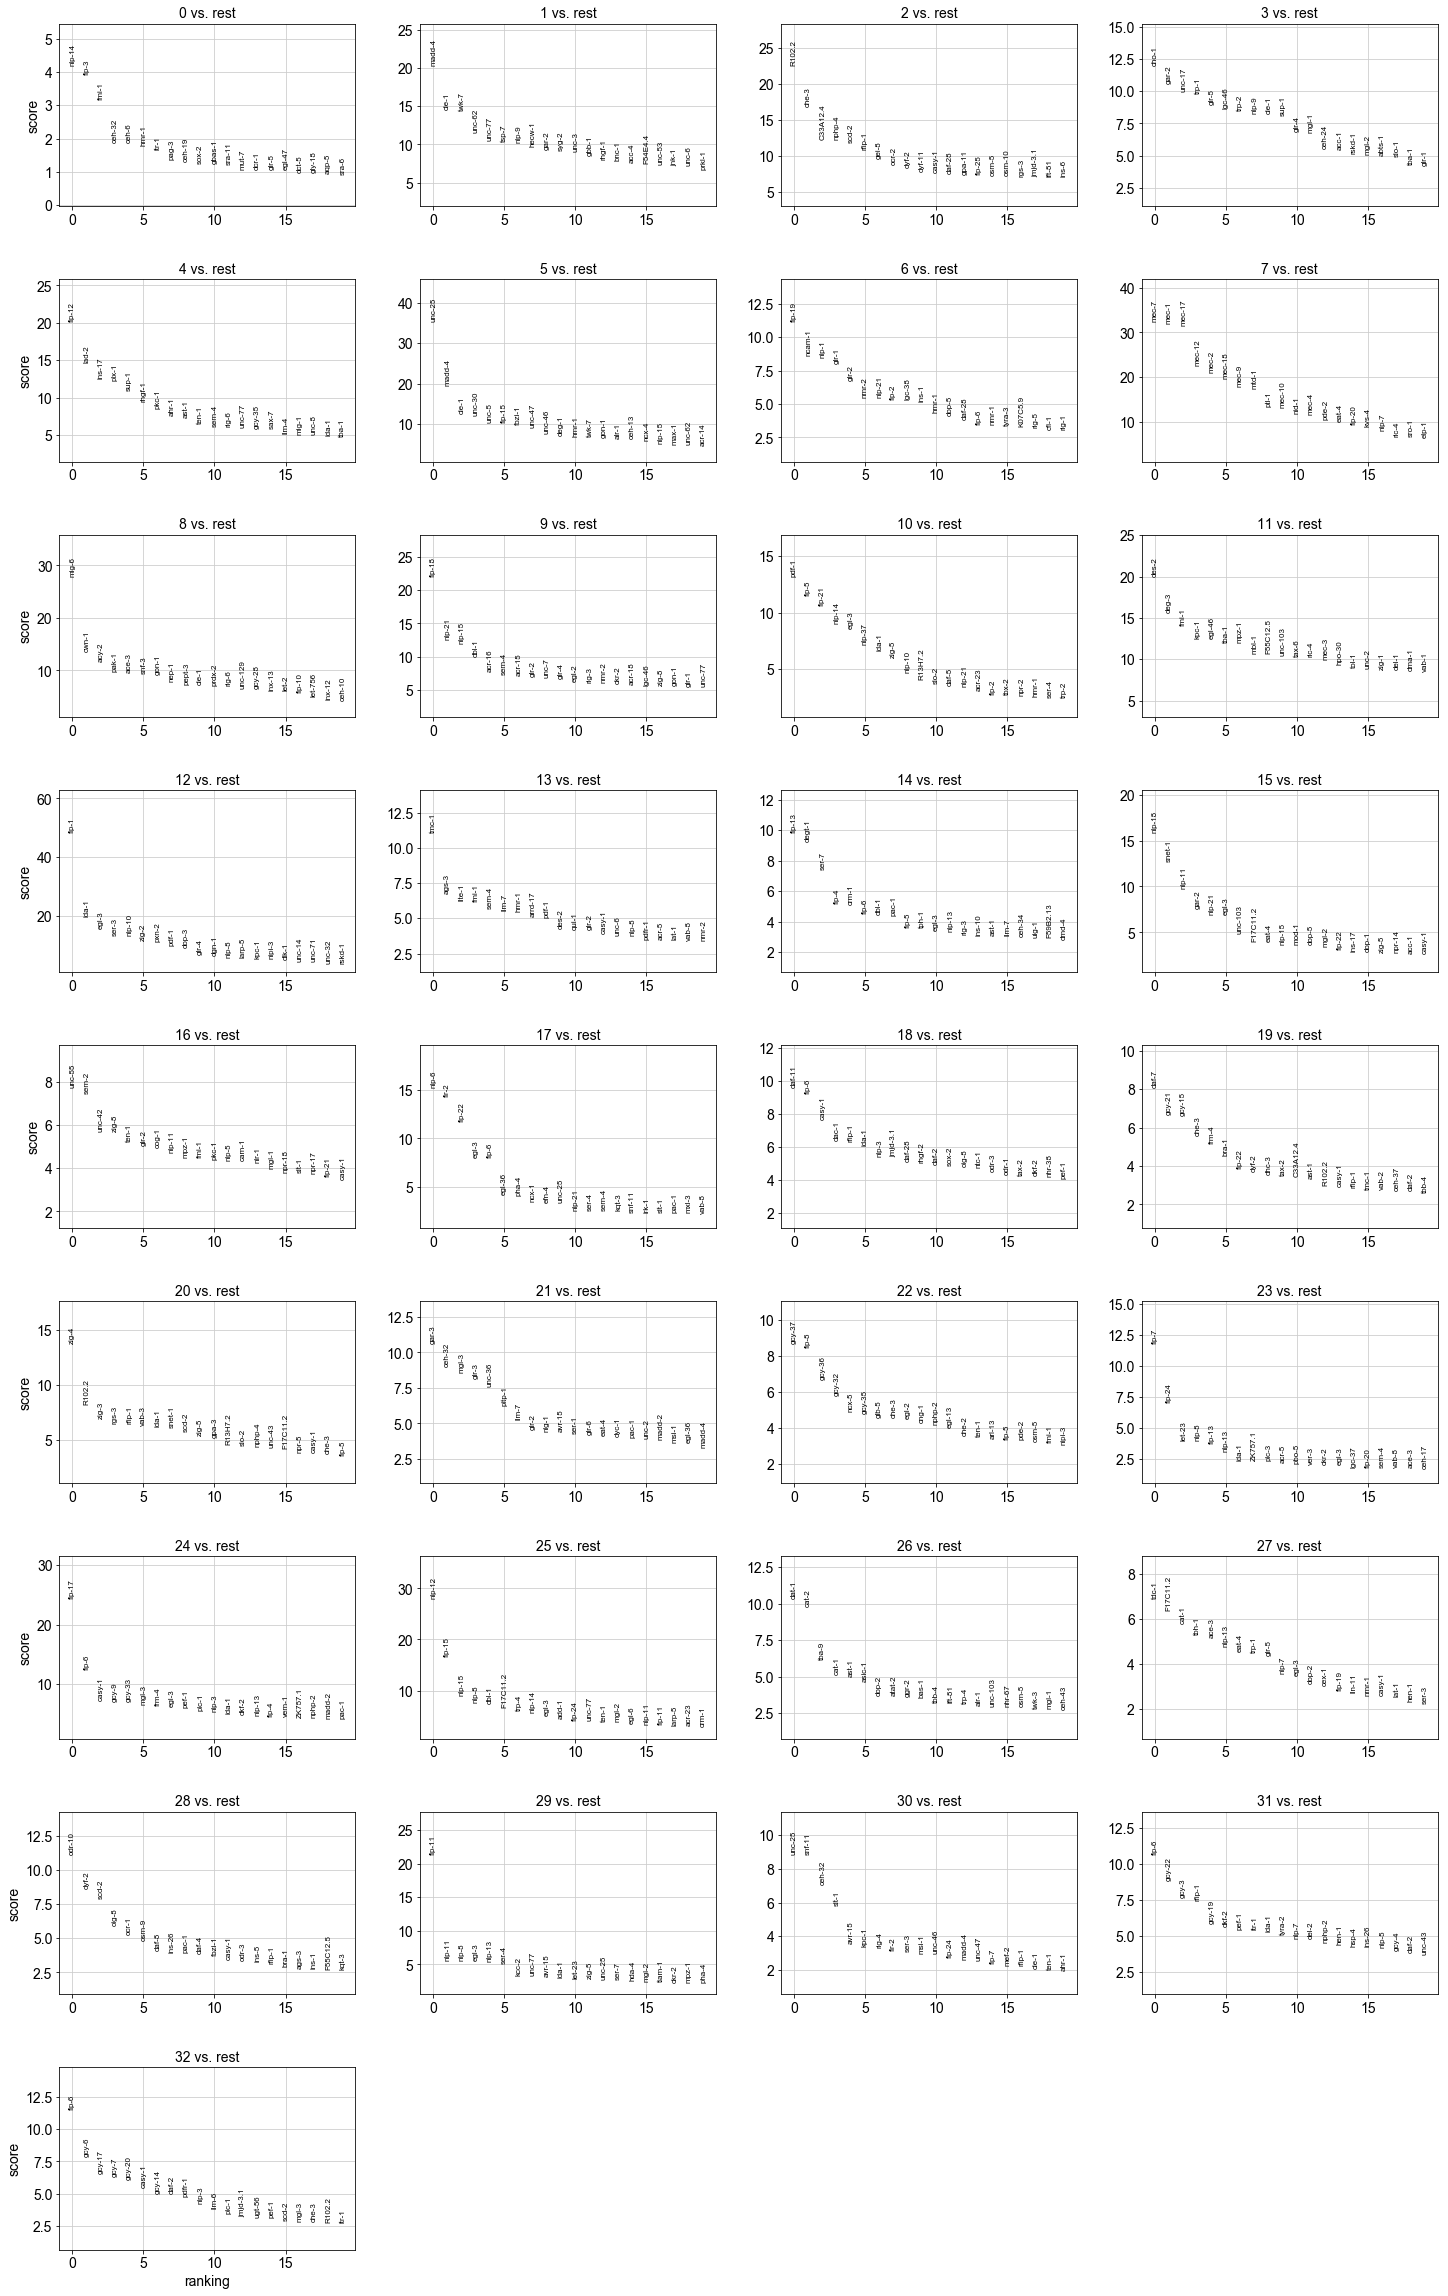

In [41]:
adata, clusters = run(df[df.columns[np.isin(df.columns,genes)]], prefix = 'all_no_impute', filterData=False)
# adata, clusters = run(df, prefix = 'all_no_impute', filterData=False)

In [43]:
adata.shape

(7603, 844)

In [15]:
validatationData = pd.read_pickle('data/horbert.pkl')
/print validatationData.shape
genes = validatationData.columns[1:]

(118, 968)


In [30]:
Counter(np.isin(genes, list(adata.var_names)))

Counter({False: 123, True: 844})

In [44]:
with open('data/no_imputation_clusters.pickle', 'wb') as handle:
    pickle.dump(clusters, handle)

# Split clusters

Cluster 0 has 886 cells
... reading from cache file ./cache/data-no_impute_cluster0_matrix.h5ad
Original size (886, 12355)
filtered out 7161 genes that are detected in less than 3 cells


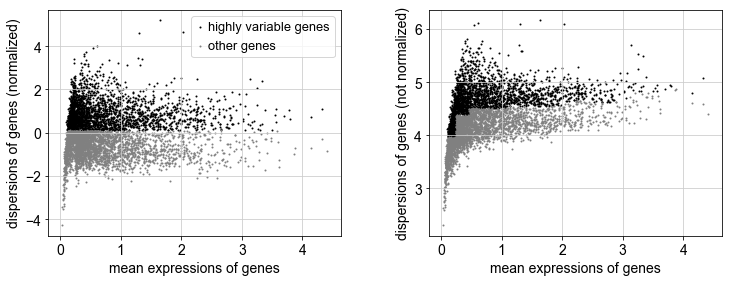

After dispersion filter (886, 2327)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.17)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.24) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.55) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.07) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/no_impute_cluster0.png


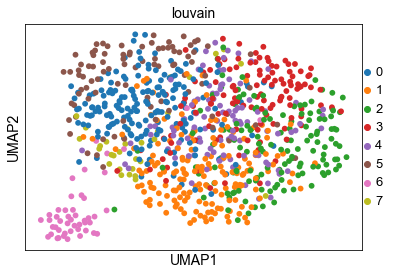

0    187
1    167
2    139
3    121
4    104
5     90
6     47
7     31
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.06) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/no_impute_cluster0.pdf


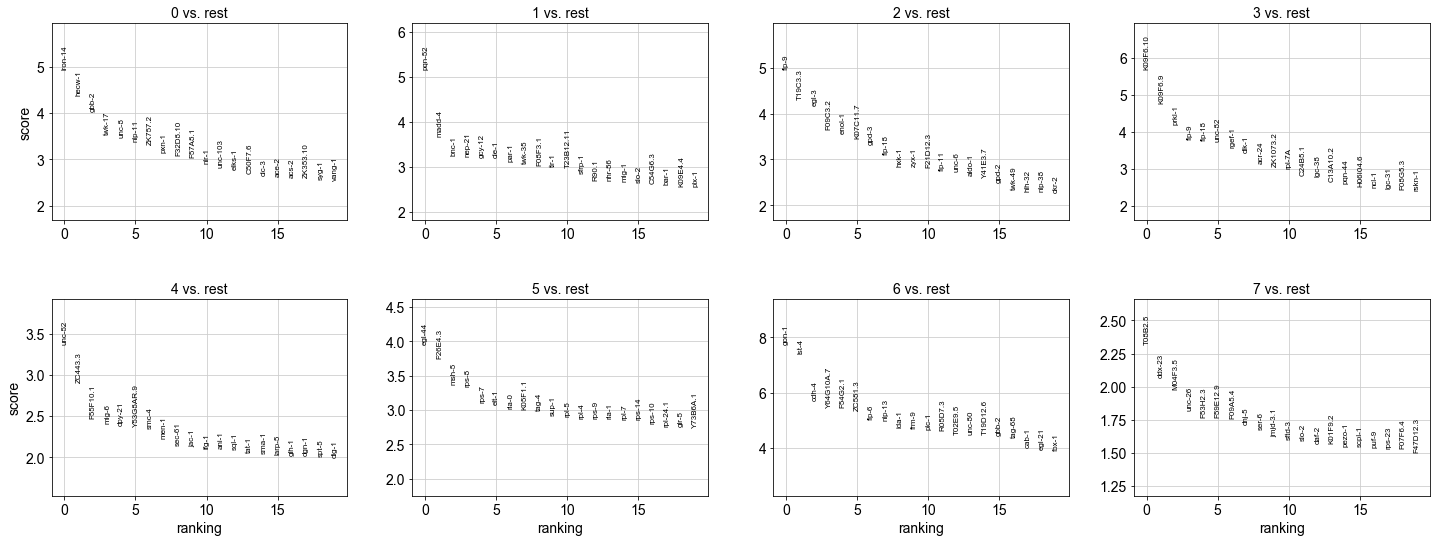

Cluster 1 has 866 cells
... reading from cache file ./cache/data-no_impute_cluster1_matrix.h5ad
Original size (866, 12355)
filtered out 7437 genes that are detected in less than 3 cells


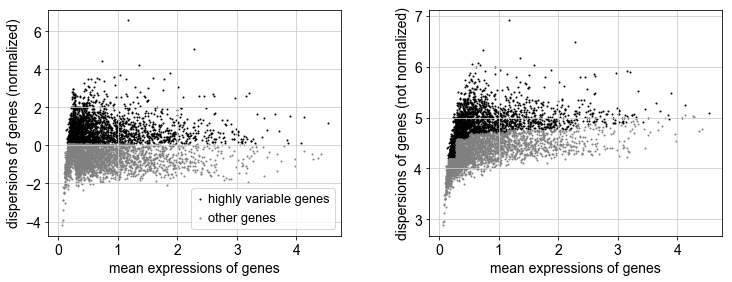

After dispersion filter (866, 2145)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.78)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.24) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.05) --> found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/no_impute_cluster1.png


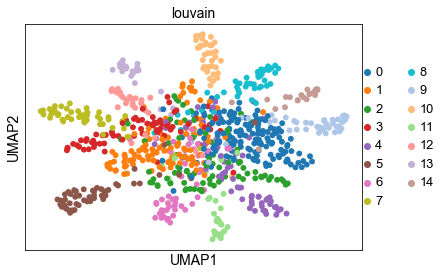

0     157
1     109
2      83
3      73
4      64
5      51
6      49
7      47
8      45
9      42
10     41
11     32
12     29
13     23
14     21
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.11) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/no_impute_cluster1.pdf


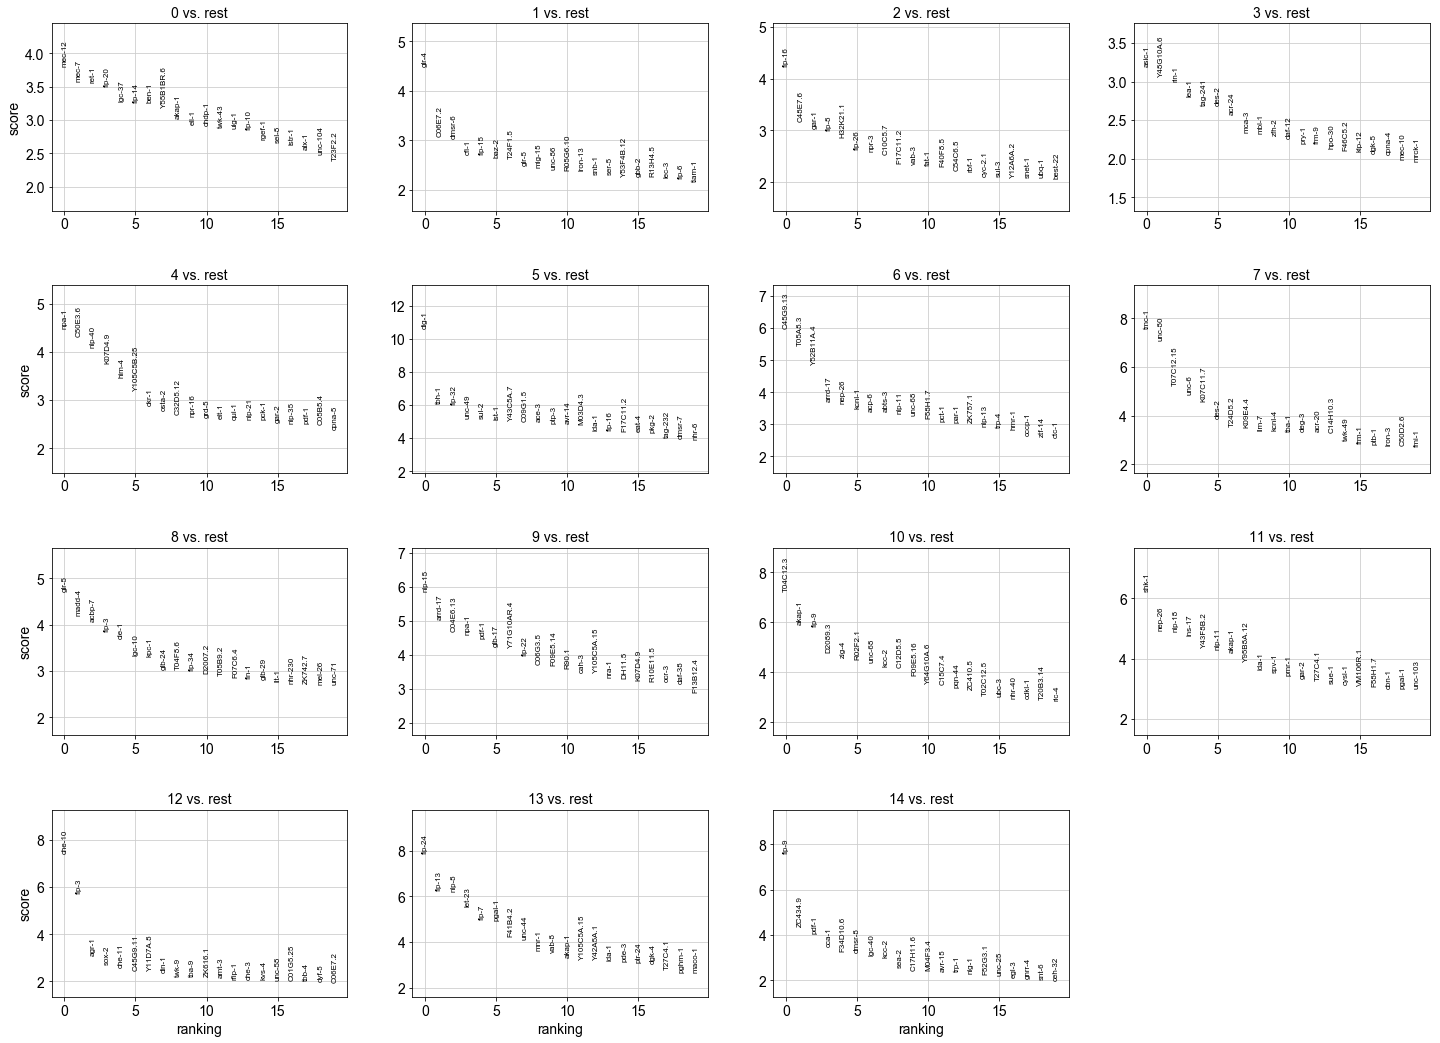

In [5]:
for clusterId in ['0', '1']:
    clusterCells = getCellsFromCluster(adata, clusterId = clusterId)
    print(f'Cluster {clusterId} has {len(clusterCells)} cells')
    adata_t, _ = run(df[df.index.isin(clusterCells)], prefix = f'no_impute_cluster{clusterId}')

# Use imputed data

In [6]:
df = pd.read_pickle('data/imputed_df.pkl')

... reading from cache file ./cache/data-all_imputed_matrix.h5ad
Original size (7603, 12355)
filtered out 123 genes that are detected in less than 3 cells


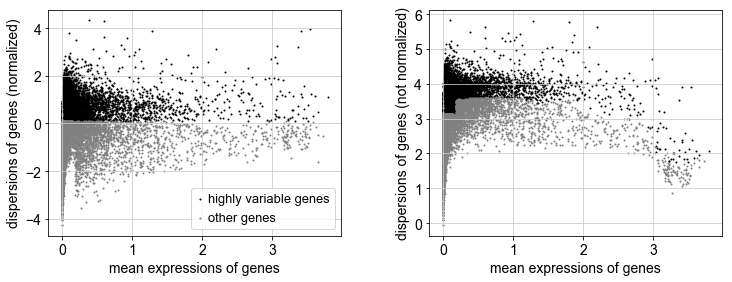

After dispersion filter (7603, 6231)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:41.48)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03.21) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:11.47) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.87) --> found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/all_imputed.png


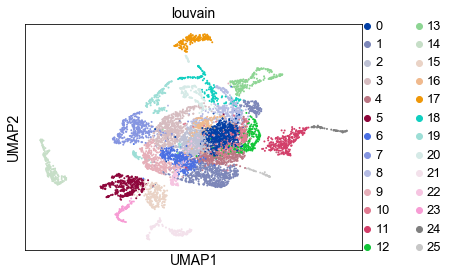

0     805
1     627
2     575
3     543
4     442
5     389
6     376
7     371
8     345
9     328
10    312
11    289
12    255
13    225
14    223
15    223
16    184
17    180
18    160
19    152
20    150
21    142
22    126
23     93
24     56
25     32
Name: louvain, dtype: int64
ranking genes
    finished (0:00:04.67) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/all_imputed.pdf


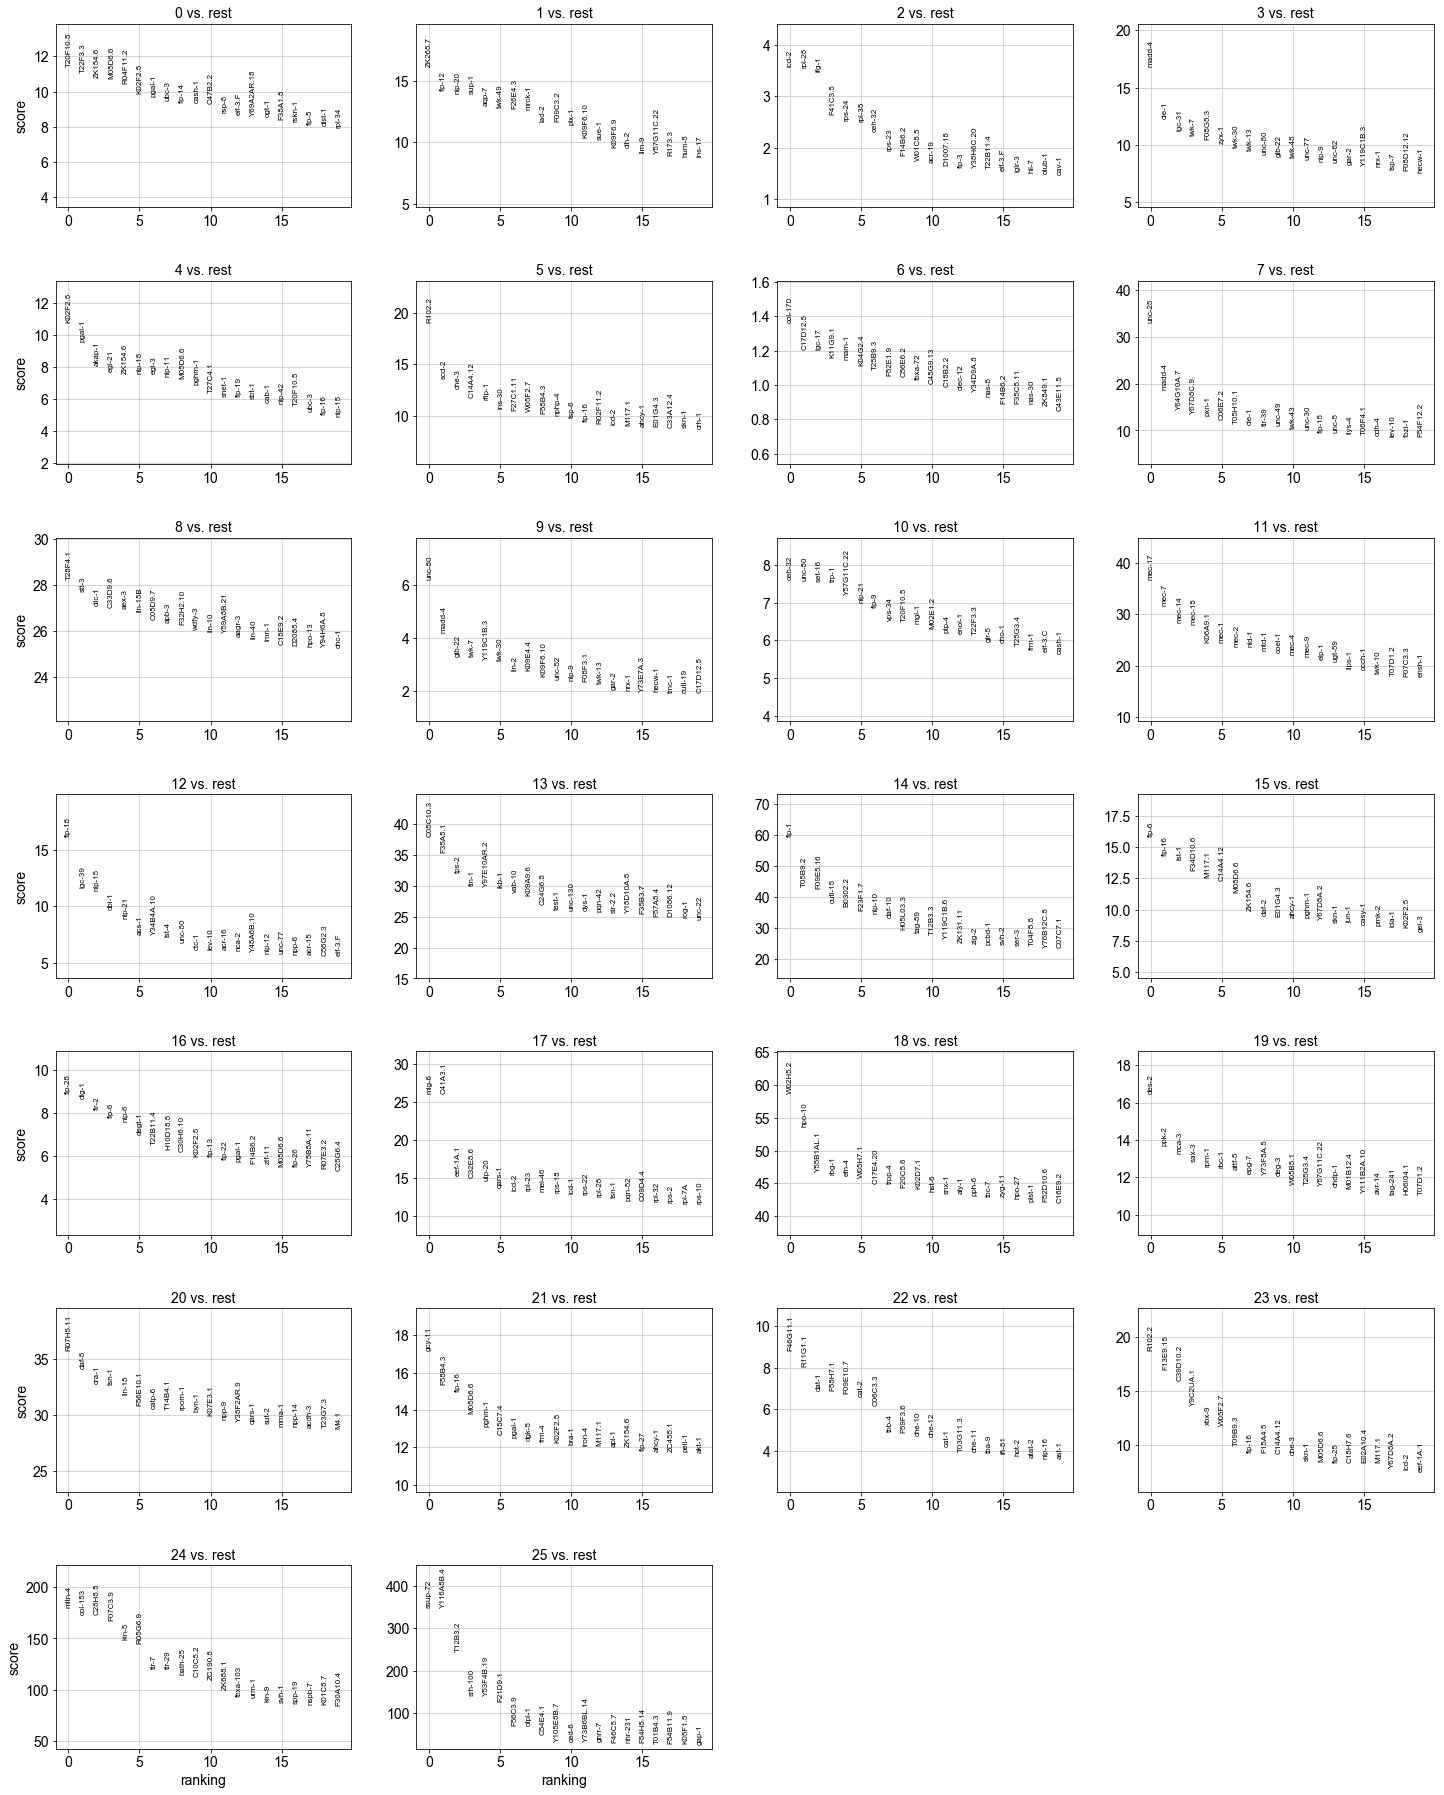

In [7]:
adata, clusters = run(df, prefix = 'all_imputed')

Cluster 0 has 805 cells
... reading from cache file ./cache/data-imputed_cluster0_matrix.h5ad
Original size (805, 12355)
filtered out 7195 genes that are detected in less than 3 cells


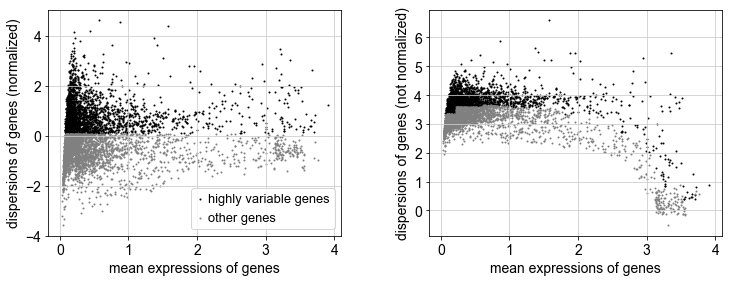

After dispersion filter (805, 2213)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.59)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.21) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.31) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.05) --> found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/imputed_cluster0.png


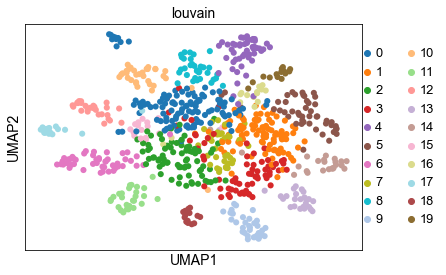

0     113
1      93
2      77
3      67
4      48
5      47
6      47
7      38
8      33
9      33
10     33
11     27
12     27
13     25
14     23
15     16
16     15
17     15
18     14
19     14
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.33) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/imputed_cluster0.pdf


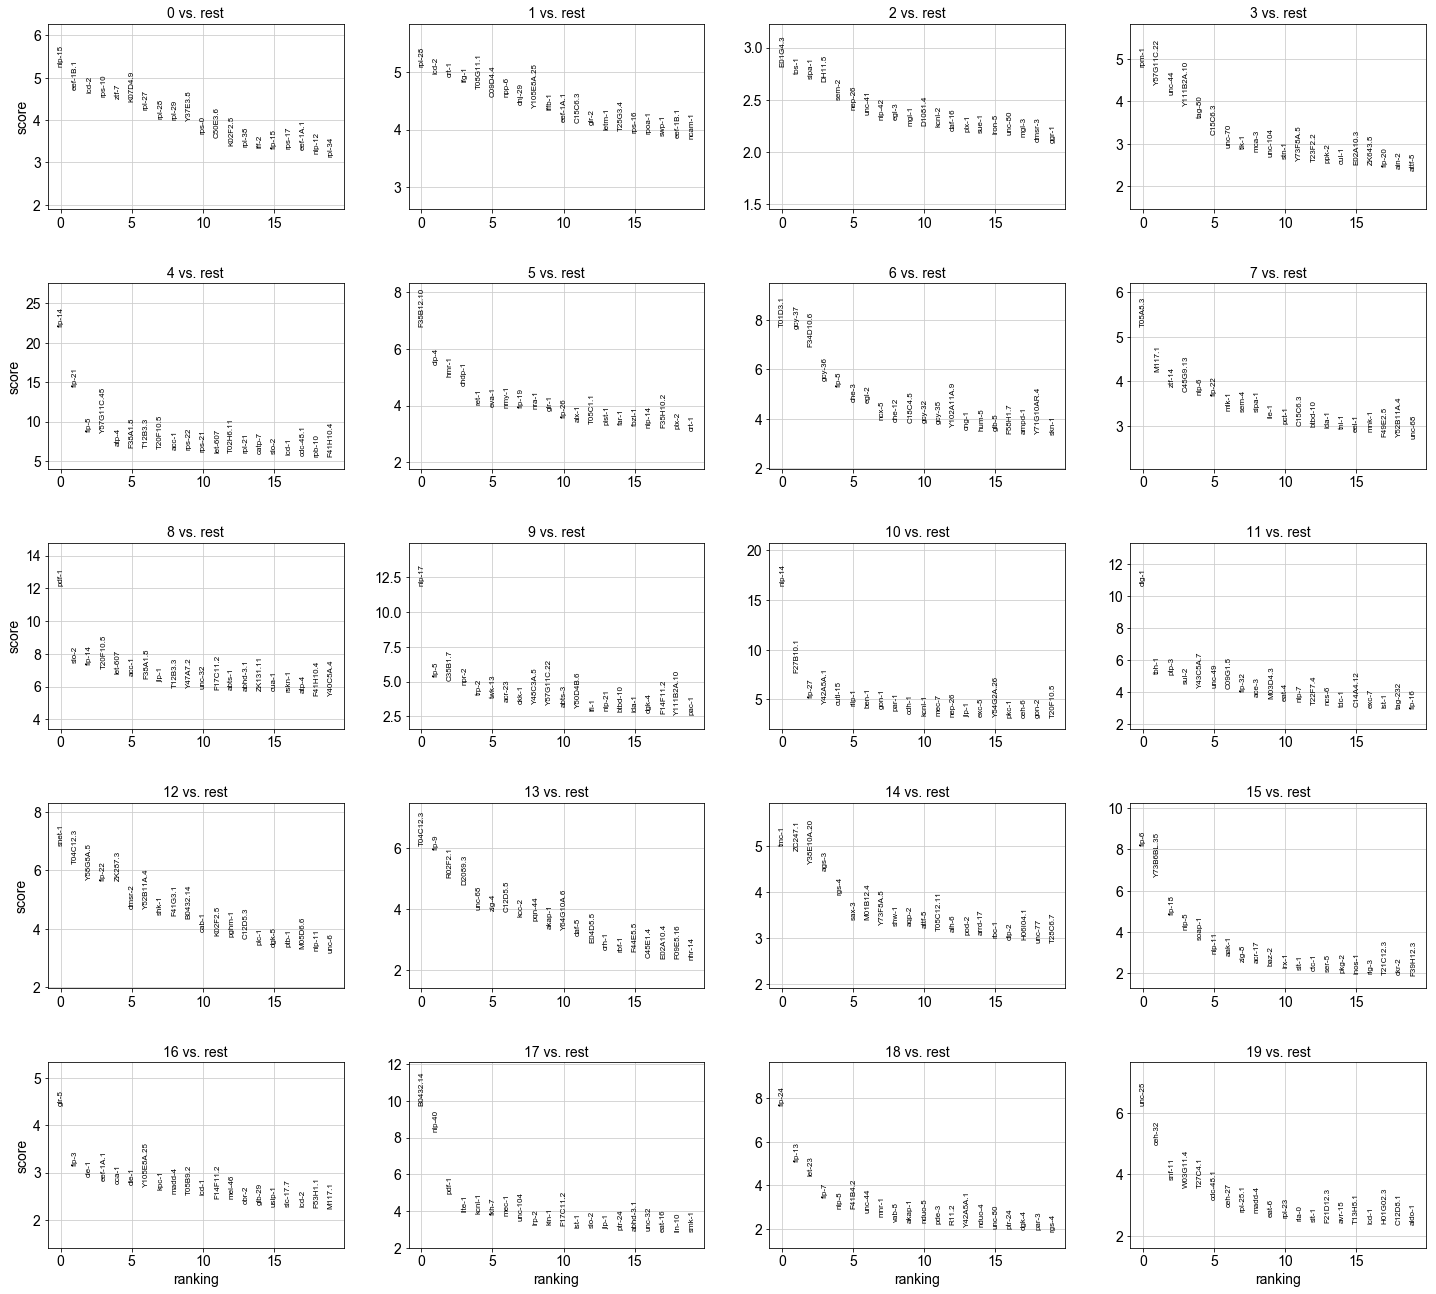

Cluster 1 has 627 cells
... reading from cache file ./cache/data-imputed_cluster1_matrix.h5ad
Original size (627, 12355)
filtered out 7694 genes that are detected in less than 3 cells


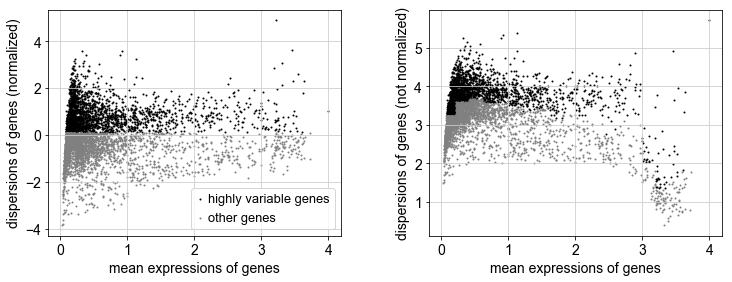

After dispersion filter (627, 2114)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.33)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.18) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.06) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.03) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/imputed_cluster1.png


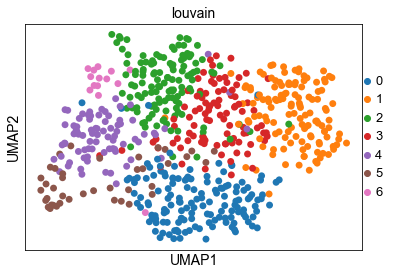

0    145
1    130
2    124
3     95
4     79
5     40
6     14
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.07) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/imputed_cluster1.pdf


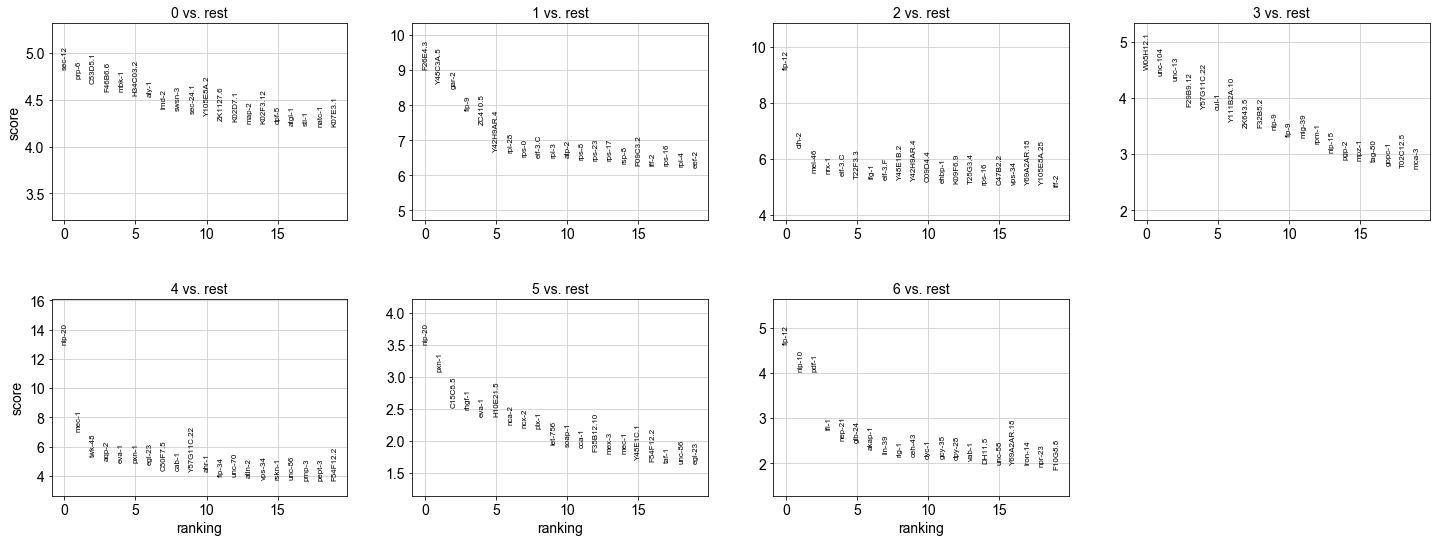

Cluster 2 has 575 cells
... reading from cache file ./cache/data-imputed_cluster2_matrix.h5ad
Original size (575, 12355)
filtered out 7979 genes that are detected in less than 3 cells


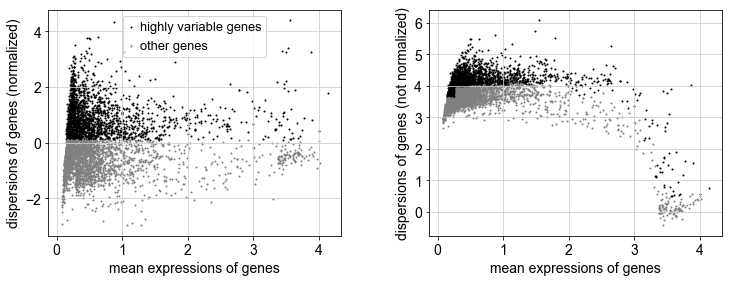

After dispersion filter (575, 1873)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.86)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.19) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.04) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.10) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/imputed_cluster2.png


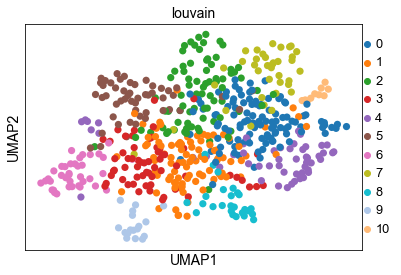

0     113
1      92
2      78
3      61
4      52
5      51
6      38
7      37
8      26
9      17
10     10
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.07) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/imputed_cluster2.pdf


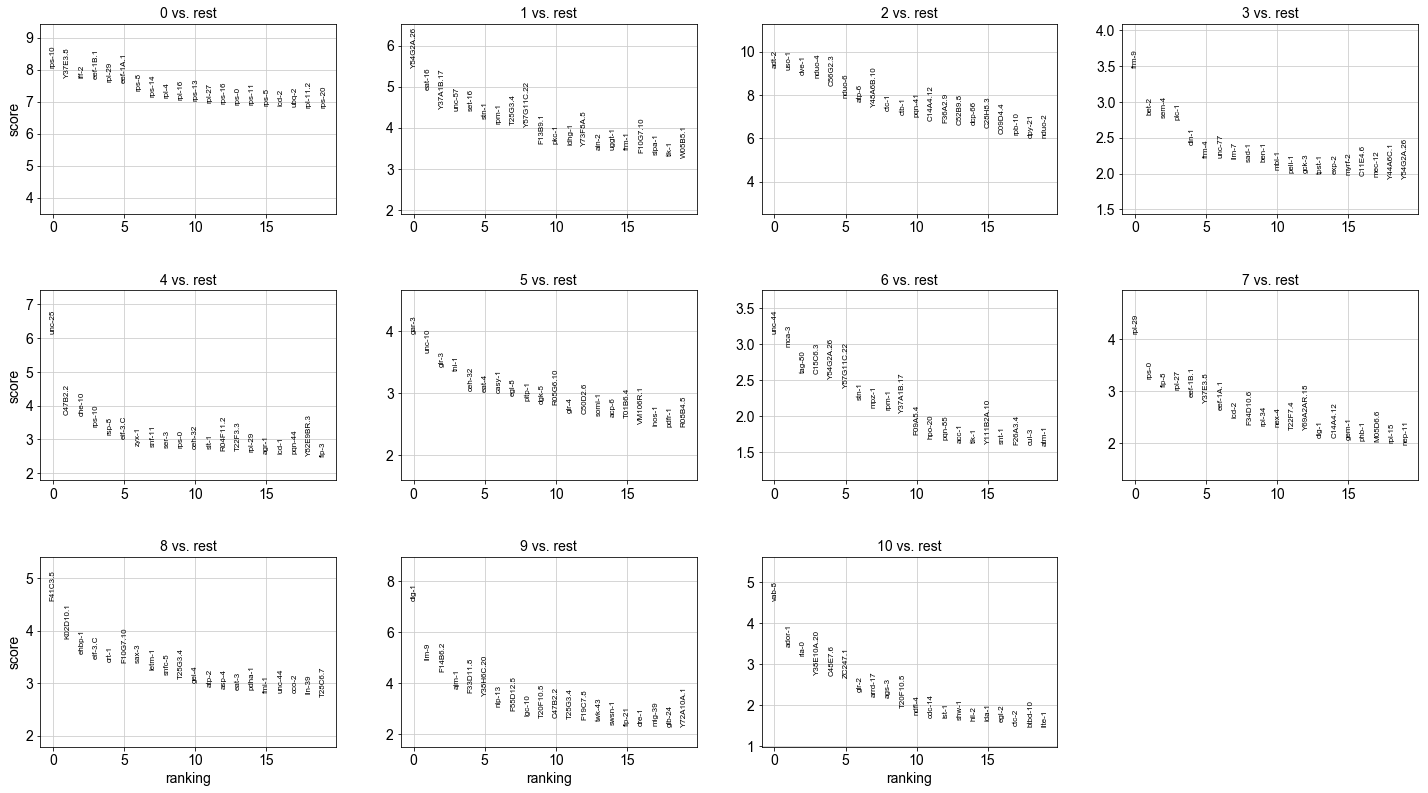

Cluster 3 has 543 cells
... reading from cache file ./cache/data-imputed_cluster3_matrix.h5ad
Original size (543, 12355)
filtered out 7870 genes that are detected in less than 3 cells


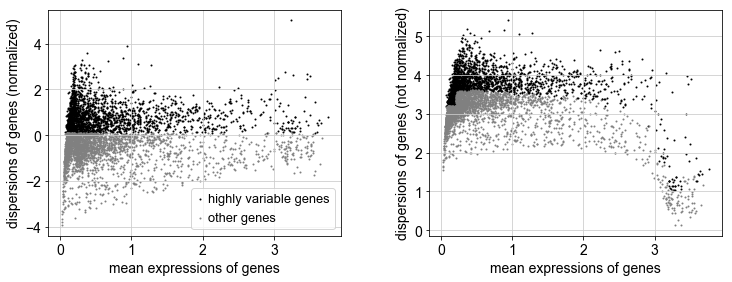

After dispersion filter (543, 2037)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:03.90)
computing neighbors
    using 'X_pca' with n_pcs = 40


C:\Users\ciort\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.98) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.04) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
saving figure to file ./figures/umap/imputed_cluster3.png


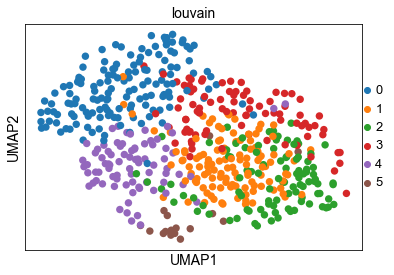

0    145
1    119
2     98
3     86
4     79
5     16
Name: louvain, dtype: int64
ranking genes
    finished (0:00:00.05) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain/imputed_cluster3.pdf


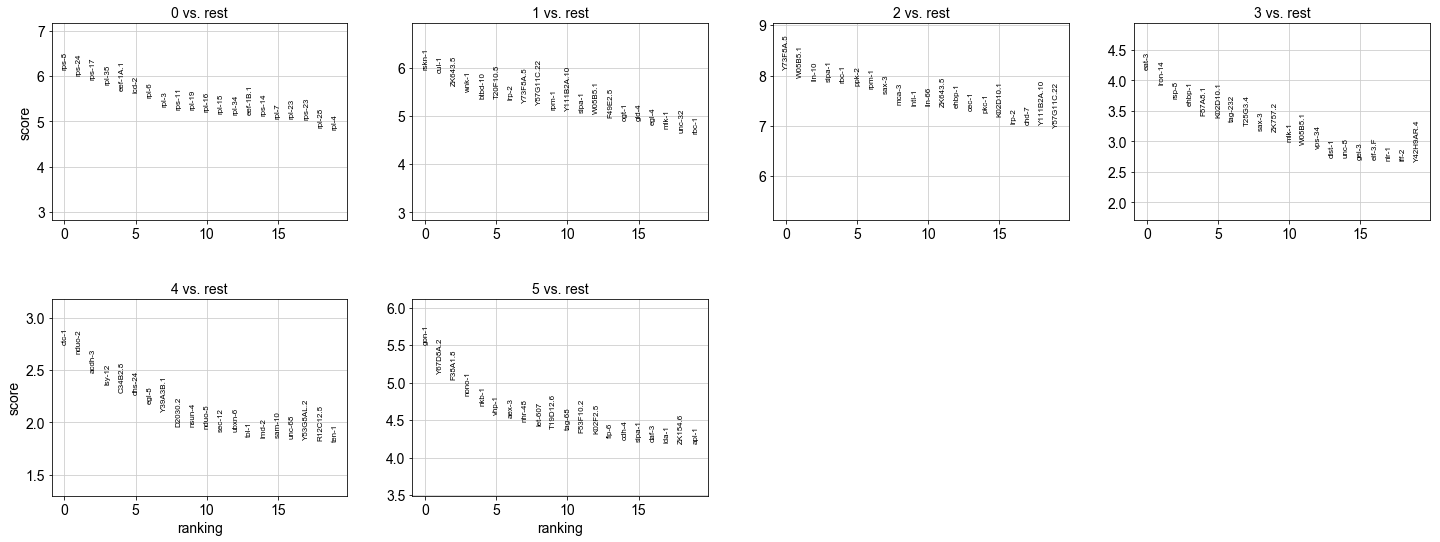

In [8]:
for clusterId in ['0', '1', '2', '3']:
    clusterCells = getCellsFromCluster(adata, clusterId = clusterId)
    print(f'Cluster {clusterId} has {len(clusterCells)} cells')
    adata_t, _ = run(df[df.index.isin(clusterCells)], prefix = f'imputed_cluster{clusterId}')